In [107]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt
import os
from scipy import stats

In [4]:
folder_path = r'C:\Users\camle\Desktop\Rankin-Lab\VG923_VG929_ATR_09_17_2020'

os.chdir(folder_path) #<- setting your working directory so that your images will be saved here

filelist = list() #<- empty list
for root, dirs, files in os.walk(folder_path): #<- this for loop goes through your folder 
    for name in files:
        if name.endswith('.dat'): #<- and takes out all files with a .dat (file that contains your data)
            filepath = os.path.join(root, name) #<- Notes down the file path of each data file
            filelist.append(filepath) #<- saves it into the list
    
print(filelist)

['C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_VG929_ATR_09_17_2020\\VG923\\20200917_133144\\VG923_15x3_n72h20C_300s5x60s_C0917_ab.dat', 'C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_VG929_ATR_09_17_2020\\VG923\\20200917_133642\\VG923_15x3_n72h20C_300s5x60s_B0917_ac.dat', 'C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_VG929_ATR_09_17_2020\\VG923\\20200917_142223\\VG923_15x3_n72h20C_300s5x60s_C0917_ae.dat', 'C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_VG929_ATR_09_17_2020\\VG923\\20200917_142720\\VG923_15x3_n72h20C_300s5x60s_B0917_af.dat', 'C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_VG929_ATR_09_17_2020\\VG923\\20200917_151233\\VG923_15x3_n72h20C_300s5x60s_C0917_ah.dat', 'C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_VG929_ATR_09_17_2020\\VG923\\20200917_151759\\VG923_15x3_n72h20C_300s5x60s_B0917_ai.dat', 'C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_VG929_ATR_09_17_2020\\VG929\\20200917_135545\\VG929_15x3_n72h20C_300s5x60s_C0917_bd.dat', 'C:\\Users\\camle\\Desktop\\Rankin-Lab\\VG923_V

In [85]:
def bin_data(df):
    """
    Groups and cleans data into discrete 1s bins and drops all NaN rows. Returns the binned/cleaned dataframe
    
    Parameters
    ----------
    df : pandas Series
    """
    
    bin_values = np.linspace(0, 1200, 800) # 1.5s bins
#     bin_values = np.arange(600) # 2s bins
    bin_labels = np.arange(1, len(bin_values))
    # We want this to be 1, len(bin_values) because labels must be one less than the total number of bin_values

    df['time_bin'] = pd.cut(df[0], bin_values, labels=bin_labels)

    df['time_bin'] = pd.to_numeric(df['time_bin'])
    df['time'] = df['time_bin'] * 1.5

    binned_df = df.groupby('time_bin').agg('mean')

    binned_df = binned_df.rename(columns={1: "speed"})
    binned_df = binned_df.drop(columns=[0, 2, 3, 4, 5])
    binned_df = binned_df[['time', 'speed']] # Reorder columns

    return binned_df

In [86]:
all_data = pd.DataFrame()

plate_number = 1

for file in filelist:
    
    if 'VG923_15x3_' in file:
        df = pd.read_csv(file, sep=' ', skiprows = 0, header = None)
        
        df = bin_data(df)
        
        df['rate_of_change'] = df['speed'].diff()/df['time'].diff()        
        df['strain'] = 'VG923'       
        df['plate_number'] = plate_number
        df.columns = ['time', 'speed', 'rate_of_change','strain', 'plate_number']
        
        
        all_data = pd.concat([all_data, df], ignore_index = True)        
        plate_number += 1
        
    elif 'VG929_15x3_' in file:
        df = pd.read_csv(file, sep=' ', skiprows = 0, header = None)
        
        df = bin_data(df)
        
        df['rate_of_change'] = df['speed'].diff()/df['time'].diff()        
        df['strain'] = 'VG929'       
        df['plate_number'] = plate_number
        df.columns = ['time', 'speed', 'rate_of_change','strain', 'plate_number']
        
        
        all_data = pd.concat([all_data, df], ignore_index = True)        
        plate_number += 1

all_data.to_csv('recovery.csv', index=False)

In [87]:
recovery_data = pd.read_csv(r'C:\Users\camle\Desktop\Rankin-Lab\VG923_VG929_ATR_09_17_2020\recovery.csv')

recovery_data.head()

,time,speed,rate_of_change,strain,plate_number
0,1.5,0.000000,NaN,VG923,1
1,3.0,0.055774,0.037182,VG923,1
2,4.5,0.239395,0.122414,VG923,1
3,6.0,0.221284,-0.012074,VG923,1
4,7.5,0.201732,-0.013035,VG923,1


In [9]:
def analyze_by_plate(df, start, stop):
    """
    Takes a start time and an end time in seconds and analyzes and plots worm data from each plate
    seperately
    
    Parameters
    ----------
    df : pandas Series
    start : float
    stop : float
    
    """
    small_df = all_data.loc[(all_data['time'] <= stop) & (all_data['time'] >= start)]
    
    plt.figure(linewidth = 0.1)
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1,2)
    sns.despine()

    ax1=sns.lineplot(x="time", 
                 y="rate_of_change", 
                 data = small_df,
                 hue = 'plate_number',
                 style = 'strain',
                 palette = 'deep',
                ax=ax[0])

    ax2=sns.lineplot(x="time", 
                 y="speed", 
                 data = small_df,
                 hue = 'plate_number',
                 style = 'strain',
                 palette = 'deep',
                 ax=ax[1])

    ax1.set_title('Rate of Change vs Time')
    ax2.set_title('Speed vs Time')

    ax1.set_ylabel('Rate of Change')
    ax2.set_ylabel('Speed')

    ax1.set_xlabel('Time (s)')
    ax2.set_xlabel('Time (s)')

    ax1.get_legend().remove()

    # Put the legend out of the figure
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '13')

    fig.show()


In [10]:
def analyze_by_plate2(df, start, stop):
    """
    Takes a start time and an end time in seconds and analyzes and plots worm data from each plate
    seperately. This uses a different visualization method than analyze_by_plate
    
    Parameters
    ----------
    df : pandas Series
    start : float
    stop : float
    
    """
    small_df = all_data.loc[(all_data['time'] <= stop) & (all_data['time'] >= start)]
    
    plt.figure(linewidth = 0.1)
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1,2)
    sns.despine()

    ax1=sns.lineplot(x="time", 
                 y="rate_of_change", 
                 data = small_df,
                 hue = 'strain',
                 style = 'strain',
                 units = 'plate_number',
                 estimator = None,
                 palette = 'deep',
                ax=ax[0])

    ax2=sns.lineplot(x="time", 
                 y="speed", 
                 data = small_df,
                 hue = 'strain',
                 style = 'strain',
                 units = 'plate_number',
                 estimator = None,
                 palette = 'deep',
                 ax=ax[1])
|
    ax1.set_title('Rate of Change vs Time')
    ax2.set_title('Speed vs Time')

    ax1.set_ylabel('Rate of Change')
    ax2.set_ylabel('Speed')

    ax1.set_xlabel('Time (s)')
    ax2.set_xlabel('Time (s)')

    ax1.get_legend().remove()

    # Put the legend out of the figure
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '13')

    fig.show()
    
    return None


SyntaxError: invalid syntax (<ipython-input-10-59a39fe92e00>, line 40)

In [11]:
def analyze_data(df, start, stop, plate):
    """
    Takes a start time and an end time in seconds and analyzes and plots worm data from a given plate.
    Plots data from all plates if plate is 'all'
    
    Parameters
    ----------
    df : pandas Series
    start : float
    stop : float
    plate : int in range[1, 12], or str
    
    """
    if plate != 'all':
        small_df = all_data.loc[(all_data['time'] <= stop) & (all_data['time'] >= start) & \
                                (all_data['plate_number'] == plate)]
    else:
        small_df = all_data.loc[(all_data['time'] <= stop) & (all_data['time'] >= start)]
    
    plt.figure(linewidth = 0.1)
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1,2)
    sns.despine()

    ax1=sns.lineplot(x="time", 
                 y="rate_of_change", 
                 data = small_df,
                 hue = 'strain',
                 palette = 'deep',
                ax=ax[0])

    ax2=sns.lineplot(x="time", 
                 y="speed", 
                 data = small_df,
                 hue = 'strain',
                 palette = 'deep',
                 ax=ax[1])

    ax1.set_title('Rate of Change vs Time')
    ax2.set_title('Speed vs Time')

    ax1.set_ylabel('Rate of Change')
    ax2.set_ylabel('Speed')

    ax1.set_xlabel('Time (s)')
    ax2.set_xlabel('Time (s)')

    ax1.get_legend().remove()

    # Put the legend out of the figure
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '13')

    fig.show()

    ### Add statistics above the figure
    stats = small_df.groupby(['strain']).agg('mean')
    stats = stats.drop(columns=['time', 'plate_number'])
    stats.columns = ['avg speed', 'avg rate_of_change']

    # Analyzing first 2s
    first_2 = all_data.loc[(all_data['time'] <= start+4) & (all_data['time'] >= start+2)]

    stats1 = first_2.groupby(['strain']).agg('mean')
    stats1 = stats1.drop(columns=['time', 'plate_number'])
    stats1.columns = ['avg speed in first 2s', 'avg rate_of_change in first 2s']

    stats = pd.concat([stats,stats1], axis=1)
    return stats



<ipython-input-162-2c712080ee4b>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-164-fefddc3abc7d>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,avg speed,avg rate_of_change,avg speed in first 2s,avg rate_of_change in first 2s
strain,,,,
VG923,0.172258,0.001447,0.129386,0.002806
VG929,0.262597,0.000243,0.257143,0.003558


<Figure size 432x288 with 0 Axes>

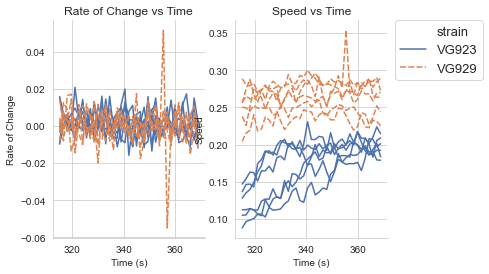

<Figure size 432x288 with 0 Axes>

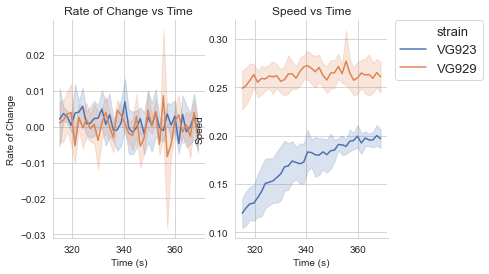

In [173]:
analyze_by_plate2(all_data, 315, 369)
analyze_data(all_data, 315, 369, 'all')

In [93]:
small_df = recovery_data.loc[(recovery_data['time'] <= 369) & (recovery_data['time'] >= 315)]

small_df.head()

,time,speed,rate_of_change,strain,plate_number
209,315.0,0.147084,0.014709,VG923,1
210,316.5,0.154239,0.004770,VG923,1
211,318.0,0.163139,0.005933,VG923,1
212,319.5,0.162368,-0.000514,VG923,1
213,321.0,0.151158,-0.007474,VG923,1


In [98]:
# We want to take the mean ROC at each 1.5 second interval for each strain individually, and plot that
# This way we should have one data point, per strain, per second, eliminating noise and allowing us
# to model a linear regression line

small_df = small_df.groupby(['time', 'strain'], as_index=True).mean()
small_df.reset_index(level=0, inplace=True)
small_df.reset_index(level=0, inplace=True)

### Since we averaged every 1.5s, plate_number has no meaning anymore
small_df = small_df.drop(columns=['plate_number'])


small_df


,strain,time,speed,rate_of_change
0,VG923,315.0,0.119658,0.002117
1,VG929,315.0,0.249015,0.001103
2,VG923,316.5,0.125177,0.003679
3,VG929,316.5,0.251806,0.001861
4,VG923,318.0,0.129386,0.002806
...,...,...,...,...
69,VG929,366.0,0.259273,-0.002675
70,VG923,367.5,0.200064,0.003064
71,VG929,367.5,0.265219,0.003964
72,VG923,369.0,0.196785,-0.002186


<Figure size 432x288 with 0 Axes>

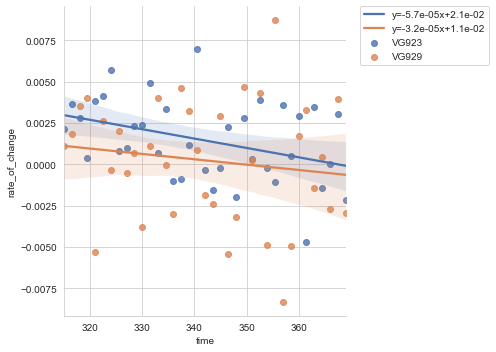

In [173]:
plt.figure(linewidth = 0.1)
sns.set_style("whitegrid")
sns.despine()

p=sns.lmplot(x="time", 
     y="rate_of_change", 
     data = small_df,
     hue = 'strain',
     palette = 'deep',
     legend=False,
     line_kws={'label':"Linear Reg"}
    )



ax = p.axes[0, 0]
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg = ax.get_legend()
L_labels = leg.get_texts()
# assuming you computed r_squared which is the coefficient of determination somewhere else
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(VG923_only['time'], VG923_only['rate_of_change'])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(VG929_only['time'], VG929_only['rate_of_change'])

label_line_1 = r'y={0:.1e}x+{1:.1e}'.format(slope1,intercept1)
label_line_2 = r'y={0:.1e}x+{1:.1e}'.format(slope2,intercept2)
L_labels[0].set_text(label_line_1)
L_labels[1].set_text(label_line_2)



In [135]:
VG923_only = small_df.loc[(small_df['strain'] == 'VG923')]
VG929_only = small_df.loc[(small_df['strain'] == 'VG929')] 

# get coeffs of linear fit for VG929
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(VG923_only['time'], VG923_only['rate_of_change'])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(VG929_only['time'], VG929_only['rate_of_change'])


print(slope1)
print(slope2)

-5.6683122718221265e-05
-3.241283341786196e-05


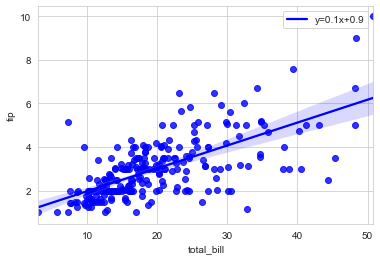

0.1050245173843534


In [145]:
tips = sns.load_dataset("tips")

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(tips['total_bill'],tips['tip'])

# use line_kws to set line label for legend
ax = sns.regplot(x="total_bill", y="tip", data=tips, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
# plot legend
ax.legend()

plt.show()

print(slope)

In [147]:
'{:0.2e}'.format(2.32432432423e25)

'2.32e+25'

Text(0.5, 19.799999999999983, 'Time (s)')

<Figure size 432x288 with 0 Axes>

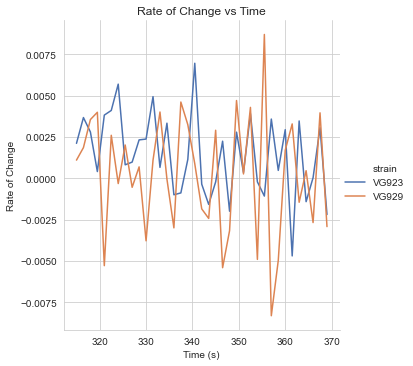

In [103]:
plt.figure(linewidth = 0.1)
sns.set_style("whitegrid")
sns.despine()

sns.relplot(x="time", 
     y="rate_of_change", 
     data = small_df,
     hue = 'strain',
     palette = 'deep',
     kind = 'line'
     )

plt.title('Rate of Change vs Time')
plt.ylabel('Rate of Change')
plt.xlabel('Time (s)')

In [119]:
path = r'C:\Users\camle\Desktop\Rankin-Lab\VG923_VG929_ATR_09_17_2020\VG929\20200917_140044\VG929_15x3_n72h20C_300s5x60s_B0917_be.dat'
file = pd.read_csv(path, sep=' ', skiprows = 0, header = None)

df = file

df

,0,1,2,3,4,5
0,0.010,0.0000,0.0,0.000000,0.000000,0.0
1,0.111,0.0000,0.0,0.000000,0.000000,0.0
2,0.173,0.0000,0.0,0.000000,0.000000,0.0
3,0.243,0.0000,0.0,0.000000,0.000000,0.0
4,0.328,0.0000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...
10834,889.693,0.2548,40.1,0.090926,0.090926,0.0
10835,889.810,0.2383,40.1,0.089899,0.089899,0.0
10836,889.917,0.2738,40.1,0.092716,0.092716,0.0
10837,890.016,0.0000,40.1,0.089634,0.089634,0.0


<function myfunc.<locals>.<lambda> at 0x0000012EE01C4D30>


In [140]:

bin_values = np.linspace(0, 1200, 800) # 1.5s bins

bin_labels = np.arange(1, len(bin_values))
# We want this to be 1, len(bin_values) because labels must be one less than the total number of bin_values

df['time_bin'] = pd.cut(df[0], bin_values, labels=bin_labels)

df['time_bin'] = pd.to_numeric(df['time_bin'])

df['time'] = df['time_bin'] * 1.5

df

,0,1,2,3,4,5,time_bin,time
0,0.010,0.0000,0.0,0.000000,0.000000,0.0,1,1.5
1,0.111,0.0000,0.0,0.000000,0.000000,0.0,1,1.5
2,0.173,0.0000,0.0,0.000000,0.000000,0.0,1,1.5
3,0.243,0.0000,0.0,0.000000,0.000000,0.0,1,1.5
4,0.328,0.0000,0.0,0.000000,0.000000,0.0,1,1.5
...,...,...,...,...,...,...,...,...
10834,889.693,0.2548,40.1,0.090926,0.090926,0.0,593,889.5
10835,889.810,0.2383,40.1,0.089899,0.089899,0.0,593,889.5
10836,889.917,0.2738,40.1,0.092716,0.092716,0.0,593,889.5
10837,890.016,0.0000,40.1,0.089634,0.089634,0.0,593,889.5


In [144]:
binned_df = df.groupby('time_bin').agg('mean')

binned_df = binned_df.rename(columns={1: "speed"})

binned_df = binned_df.drop(columns=[0, 2, 3, 4, 5])

binned_df = binned_df[['time', 'speed']] # Reorder columns

binned_df

,time,speed
time_bin,,
1,1.5,0.000000
2,3.0,0.088650
3,4.5,0.276915
4,6.0,0.268093
5,7.5,0.284075
...,...,...
589,883.5,0.290755
590,885.0,0.299033
591,886.5,0.282707


### Test this with another file

In [154]:
file = filelist[8]
df = pd.read_csv(file, sep=' ', skiprows = 0, header = None)

df.head()

,0,1,2,3,4,5
0,0.017,0.0,0.0,0.0,0.0,0.0
1,0.110,0.0,0.0,0.0,0.0,0.0
2,0.207,0.0,0.0,0.0,0.0,0.0
3,0.287,0.0,0.0,0.0,0.0,0.0
4,0.367,0.0,0.0,0.0,0.0,0.0


In [155]:
bin_values = np.linspace(0, 1200, 800) # 1.5s bins

bin_labels = np.arange(1, len(bin_values))
# We want this to be 1, len(bin_values) because labels must be one less than the total number of bin_values

df['time_bin'] = pd.cut(df[0], bin_values, labels=bin_labels)

df['time_bin'] = pd.to_numeric(df['time_bin'])

df['time'] = df['time_bin'] * 1.5

binned_df = df.groupby('time_bin').agg('mean')

binned_df = binned_df.rename(columns={1: "speed"})

binned_df = binned_df.drop(columns=[0, 2, 3, 4, 5])

binned_df = binned_df[['time', 'speed']] # Reorder columns

binned_df

,time,speed
time_bin,,
1,1.5,0.000000
2,3.0,0.102656
3,4.5,0.283026
4,6.0,0.278379
5,7.5,0.288678
...,...,...
589,883.5,0.286489
590,885.0,0.287011
591,886.5,0.287453
